random으로 타원안에 점찍기

In [ ]:
# import numpy as np
# from matplotlib.patches import Ellipse
# import folium

# # 타원의 속성 설정
# std_point = (33.37283976160554, 126.4439861097205 )
# ellipse = Ellipse((126.545633, 33.377538), width=0.75, height=0.28, angle=13)
# randAns=[]
# count = 0
# while True:
# # 랜덤 좌표 생성
#     num_points = 26 # 생성할 랜덤 점의 개수
#     x_center, y_center = ellipse.center  # 타원 중심 좌표
#     width = ellipse.width / 2  # 타원의 가로 반지름
#     height = ellipse.height / 2  # 타원의 세로 반지름
#     angle = np.deg2rad(ellipse.angle)  # 타원의 기울기 각도

#     # 타원 내의 랜덤 점 생성
#     random_points = []
#     while len(random_points) < num_points:
#         x = np.random.uniform(x_center - width, x_center + width)
#         y = np.random.uniform(y_center - height, y_center + height)
#         if ((x - x_center) / width) ** 2 + ((y - y_center) / height) ** 2 <= 1:
#             x_rot = np.cos(angle) * (x - x_center) - np.sin(angle) * (y - y_center) + x_center
#             y_rot = np.sin(angle) * (x - x_center) + np.cos(angle) * (y - y_center) + y_center
#             random_points.append((x_rot, y_rot))
#     print(random_points)
#     map_osm = folium.Map(location=std_point, zoom_start=10) 

#     for j in random_points:
#         location = (j[1], j[0]) # 위도, 경도 튜플
#         folium.Circle(
#             location=location,
#             radius=1000, 
#             color='blue',
#             weight=1,
#             fill_opacity=0.6,
#             opacity=1,
#             fill_color='black',
#             fill=True,  # gets overridden by fill_color
            
#         ).add_to(map_osm)
#     ans = input()
#     if ans == 't':
#         count +=1
#         randAns.append(random_points)

#     if count >=10:
#         break
#     print(count)
#     map_osm.save('map.html')

# import pickle

# for point in randAns:
#     print(point)
# with open('random_point.pkl', 'wb') as f:
#     pickle.dump(randAns, f)

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from haversine import haversine
import matplotlib.pyplot as plt
import math
import pickle

%matplotlib inline

def serviceArea(graph, nodelist = [], w =5):
    ret = {}
    for node in nodelist:
        shortest_paths = nx.single_source_dijkstra_path_length(graph, node, cutoff=w, weight='weight')
        tmp=ret
        for key in set(shortest_paths.keys()).intersection(ret.keys()):
            tmp[key] = min(shortest_paths[key], ret[key])
        tmp.update({key: shortest_paths[key] for key in set(shortest_paths.keys()) - set(ret.keys())})
        tmp.update({key: ret[key] for key in set(ret.keys()) - set(shortest_paths.keys())})
        ret = tmp
    return ret

def connectRes(graph, df): # df는 idx, latitude, longitude가 있어야함
    nodes_latitude = nx.get_node_attributes(graph, 'latitude')
    nodes_longitude = nx.get_node_attributes(graph, 'longitude')
    for idx, row in df.iterrows():
        distances ={}
        for keyLong, valLat in nodes_latitude.items():
            nodesPos = (valLat, nodes_longitude[keyLong])
            curPos = (row['latitude'], row['longitude'])
            distances[keyLong] = haversine(nodesPos, curPos, unit='km')
        nearest_node = min(distances, key=distances.get)
        graph.add_node(idx, Label=idx, latitude=row['latitude'], longitude=row['longitude']) ##노드이름은 4050000000이하로 설정
        w = distances[nearest_node]*1000/666 #단위 변환 km->m(*1000), 거리(m)->시간(분) (40km/h = 666m/s)
        graph.add_edge(nearest_node, idx, weight=w) 
    return graph

def adjust_distance(distance):
    ret = math.ceil(distance)
    return ret

nodes = pd.read_csv('data/Jeju_nodes.csv', encoding='utf-8')
links = pd.read_csv('data/Jeju_links.csv', encoding='cp949')
car = pd.read_csv('data/Jeju_car.csv', encoding='cp949')
with open('random_point.pkl', 'rb') as f:
    randomPoints = pickle.load(f)
    
nodes = nodes[['Id','NODE_NAME','latitude','longitude', 'average population']]
links = links[['Source','Target', '시간']]
source_in = links['Source'].apply(lambda x : x in list(nodes['Id'])) # check Sources are in jeju
target_in = links['Target'].apply(lambda x : x in list(nodes['Id'])) # check Targets are in jeju
# source_in and target_in are boolean type pandas.Series which contains True or False
jeju_links = links[source_in & target_in] # contain if both target and source are contained in jeju



거리별(정수) 노드수 그래프

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22] 23
[26.0, 33.1, 95.5, 152.6, 230.8, 318.1, 351.2, 374.6, 378.4, 347.7, 345.7, 300.6, 279.1, 239.8, 210.7, 179.8, 126.6, 92.9, 61.8, 37.6, 28.9, 17.2, 6.9] 23


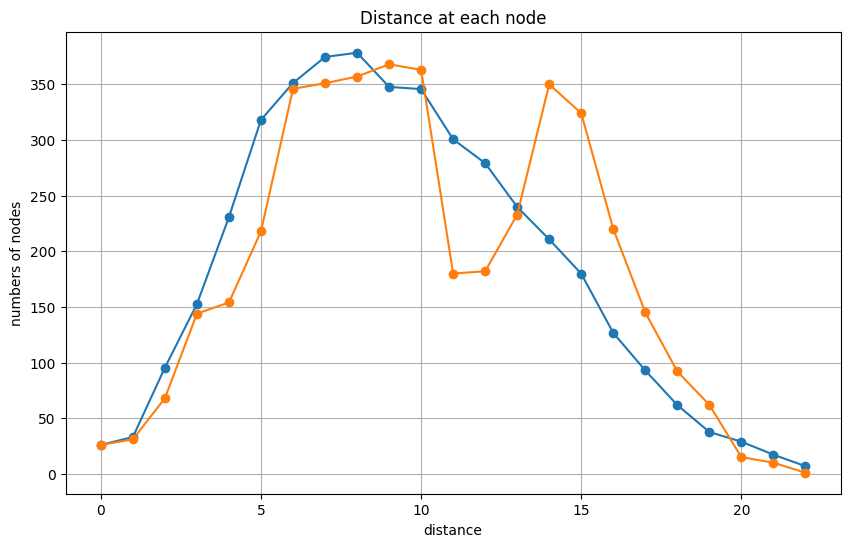

In [1]:
# ----- 여기는 현실판
G = nx.Graph()
for idx,row in nodes.iterrows():
    # add node to Graph G
    G.add_node(row['Id'],Label=row['NODE_NAME'],latitude=row['latitude'], longitude=row['longitude'])
for idx,row in jeju_links.iterrows():
    # Link attribute : 'Source', 'Target' and weight = '시간 between two nodes'
    G.add_edge(row['Source'],row['Target'],weight = row['시간'])
G = connectRes(G, car)
realNodes = [i for i in range(26)]
area = serviceArea(G, realNodes, 22)
result_df = pd.DataFrame(list(area.items()), columns=['ID', 'Distance'])
result_df['Adjusted_Distance'] = result_df['Distance'].apply(adjust_distance)
node_counts = result_df.groupby('Adjusted_Distance').size()

# 여기는 랜덤판
result_x = []
result_y = []
for pointsList in randomPoints:
    G = nx.Graph()
    for idx,row in nodes.iterrows():
        # add node to Graph G
        G.add_node(row['Id'],Label=row['NODE_NAME'],latitude=row['latitude'], longitude=row['longitude'])
    for idx,row in jeju_links.iterrows():
        # Link attribute : 'Source', 'Target' and weight = '시간 between two nodes'
        G.add_edge(row['Source'],row['Target'],weight = row['시간'])    
    # make a dictionary for node position
    columns = ['longitude','latitude']
    df = pd.DataFrame(pointsList, columns=columns)
    G = connectRes(G, df)
    random_nodes = [i for i in range(26)]
    area = serviceArea(G, random_nodes, 22)
    result_df = pd.DataFrame(list(area.items()), columns=['ID', 'Distance'])
    result_df['Adjusted_Distance'] = result_df['Distance'].apply(adjust_distance)
    node_counts = result_df.groupby('Adjusted_Distance').size()
    x = list(node_counts.index)
    if len(x) > len(result_x):
        result_x = x
    y = list(node_counts.values)
    if result_y == []:
        result_y = y
    else:
        for i in range(len(y)):
            result_y[i] = result_y[i] + y[i]
result_y = [y/10 for y in result_y]
print(result_x, len(result_x))
print(result_y, len(result_y))
# make graph
plt.figure(figsize=(10, 6))
plt.plot(result_x, result_y, marker='o')
plt.plot(node_counts.index, node_counts.values, marker='o')
plt.title('Distance at each node')
plt.xlabel('distance')
plt.ylabel('numbers of nodes')
plt.grid(True)
plt.show()

거리별(실수) 노드수(합) 그래프

4215 [26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 29, 30, 30, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 34, 34, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 54, 56, 56, 56, 56

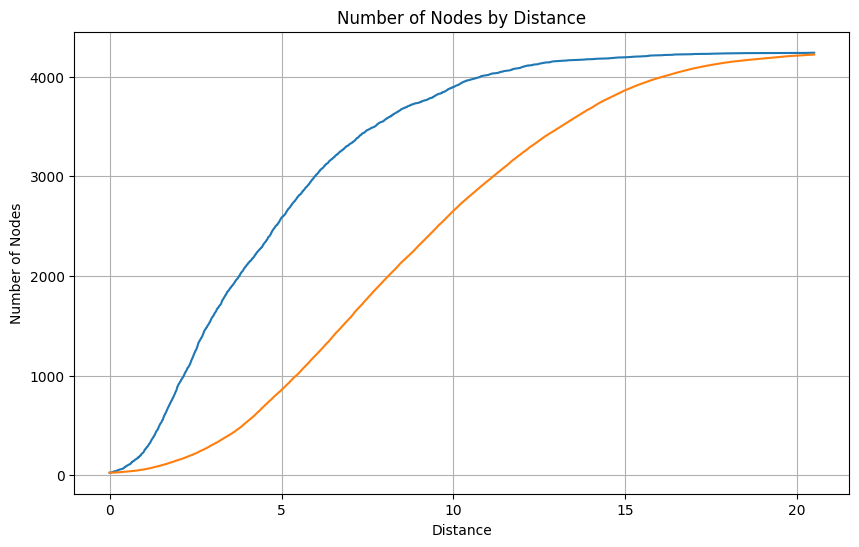

In [76]:
# ----- 여기는 현실판
G = nx.Graph()
for idx,row in nodes.iterrows():
    # add node to Graph G
    G.add_node(row['Id'],Label=row['NODE_NAME'],latitude=row['latitude'], longitude=row['longitude'])
for idx,row in jeju_links.iterrows():
    # Link attribute : 'Source', 'Target' and weight = '시간 between two nodes'
    G.add_edge(row['Source'],row['Target'],weight = row['시간'])
G = connectRes(G, car)
realNodes = [i for i in range(26)]
area = serviceArea(G, realNodes, 22)
result_df = pd.DataFrame(list(area.items()), columns=['ID', 'Distance'])
distances = sorted(result_df['Distance'].unique())
cumulative_counts = [result_df[result_df['Distance'] <= distance].shape[0] for distance in distances]


# ------- 여기는 랜덤판
result_x = []
result_y = []
iter = 0
for pointsList in randomPoints:
    iter +=1
    G = nx.Graph()
    for idx,row in nodes.iterrows():
        # add node to Graph G
        G.add_node(row['Id'],Label=row['NODE_NAME'],latitude=row['latitude'], longitude=row['longitude'])
    for idx,row in jeju_links.iterrows():
        # Link attribute : 'Source', 'Target' and weight = '시간 between two nodes'
        G.add_edge(row['Source'],row['Target'],weight = row['시간'])    
    # make a dictionary for node position
    columns = ['longitude','latitude']
    df = pd.DataFrame(pointsList, columns=columns)
    G = connectRes(G, df)
    random_nodes = [i for i in range(26)]
    area = serviceArea(G, random_nodes, 22)
    random_df = pd.DataFrame(list(area.items()), columns=['ID', 'Distance'])
    random_counts = [random_df[random_df['Distance'] <= distance].shape[0] for distance in distances]
    
    x = distances
    if len(x) > len(result_x):
        result_x = x
    y = random_counts
    print(len(y), y)
    if result_y == []:
        result_y = y
    else:
        for i in range(len(y)):
            result_y[i] = result_y[i] + y[i]
result_y = [y/10 for y in result_y]
print(result_x, len(result_x))
print(result_y, len(result_y))
print(distances, len(cumulative_counts))


distances = sorted(result_df['Distance'].unique())
cumulative_counts = [result_df[result_df['Distance'] <= distance].shape[0] for distance in distances]

# 거리별 노드 개수를 그래프로 그리기
plt.figure(figsize=(10, 6))
plt.plot(distances, cumulative_counts, marker='o', markersize = 0)
plt.plot(result_x, result_y, marker='o', markersize = 0)

# 그래프 제목과 축 이름 설정
plt.title('Number of Nodes by Distance')
plt.xlabel('Distance')
plt.ylabel('Number of Nodes')
plt.grid(True)
# 그래프 출력
plt.savefig('result/Number of Nodes by Distance.png')
plt.show()

인구수 고려

4240
4241
4215 623442.4671889998
4240
4214 623387.1027309931
4240
4214 623387.102730992
4240
4214 623387.1027310237
4240
4214 623387.1027310007
4240
4214 623387.1027309931
4240
4214 623387.1027310123
4240
4214 623387.1027309941
4240
4214 623387.1027310035
4240
4214 623387.1027310048
4214 [0.0, 0.05358281992992601, 0.05572713394703723, 0.057675469557528704, 0.06067167871664851, 0.06497805724952183, 0.0843764195791417, 0.0850409937965719, 0.10041258823944851, 0.10401844353202479, 0.10500422382127927, 0.1217300877644879, 0.12746311274287353, 0.1448500458575287, 0.14533125241350542, 0.17531371594703724, 0.17680325517451284, 0.18471438869576437, 0.19213003657914168, 0.2032682401239915, 0.21928272771664853, 0.22606989507451283, 0.22611216447926225, 0.2282083885575287, 0.22883564023944852, 0.24536678024952183, 0.2594943296575287, 0.263683760929926, 0.268115260929926, 0.2685550317644879, 0.2747272818575287, 0.2811750572394485, 0.29442863274287356, 0.2947052355791417, 0.3174195295320248, 0.3275

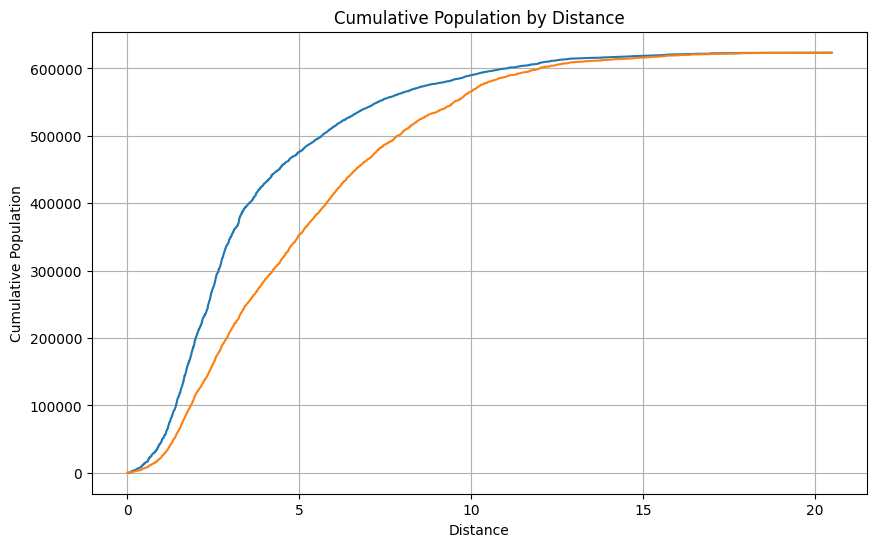

In [75]:
# ----- 여기는 현실판
G = nx.Graph()
for idx,row in nodes.iterrows():
    # add node to Graph G
    G.add_node(row['Id'],Label=row['NODE_NAME'],latitude=row['latitude'], longitude=row['longitude'])
for idx,row in jeju_links.iterrows():
    # Link attribute : 'Source', 'Target' and weight = '시간 between two nodes'
    G.add_edge(row['Source'],row['Target'],weight = row['시간'])
G = connectRes(G, car)
realNodes = [i for i in range(26)]
area = serviceArea(G, realNodes, 40)
print(len(area))
result_df = pd.DataFrame(list(area.items()), columns=['ID', 'Distance'])
merged_df = pd.merge(result_df, nodes[['Id', 'average population']], left_on='ID', right_on='Id')
grouped_data = merged_df.groupby('Distance')['average population'].sum()
cumulative_population = grouped_data.cumsum()

# ------- 여기는 랜덤판
result_x = []
result_y = []
iter = 0
for pointsList in randomPoints:
    iter +=1
    G = nx.Graph()
    for idx,row in nodes.iterrows():
        # add node to Graph G
        G.add_node(row['Id'],Label=row['NODE_NAME'],latitude=row['latitude'], longitude=row['longitude'])
    for idx,row in jeju_links.iterrows():
        # Link attribute : 'Source', 'Target' and weight = '시간 between two nodes'
        G.add_edge(row['Source'],row['Target'],weight = row['시간'])    
    # make a dictionary for node position
    columns = ['longitude','latitude']
    df = pd.DataFrame(pointsList, columns=columns)
    G = connectRes(G, df)
    random_nodes = [i for i in range(26)]
    area = serviceArea(G, random_nodes, 40)
    print(len(area))
    random_df = pd.DataFrame(list(area.items()), columns=['ID', 'Distance'])
    random_counts = [random_df[random_df['Distance'] <= distance].shape[0] for distance in distances]
    mergedRandom = pd.merge(random_df, nodes[['Id', 'average population']], left_on='ID', right_on='Id')
    groupedRandom = mergedRandom.groupby('Distance')['average population'].sum()
    randomPopulation = groupedRandom.cumsum()
    
    x = distances
    if len(x) > len(result_x):
        result_x = x
    if len(result_x) > len(cumulative_population.index):
        result_x = result_x[:len(cumulative_population.index)]
    y = randomPopulation.values.tolist()
    print(len(y), y[-1])
    if len(y) > len(cumulative_population.values):
        y = y[:len(cumulative_population.values)]
    if result_y == []:
        result_y = y
    else:
        for i in range(len(y)):
            result_y[i] = result_y[i] + y[i]
result_y = [y/10 for y in result_y]
print(len(result_x), result_x)
print(len(result_y), result_y)


distances = sorted(result_df['Distance'].unique())
cumulative_counts = [result_df[result_df['Distance'] <= distance].shape[0] for distance in distances]

plt.figure(figsize=(10, 6))
plt.plot(cumulative_population.index, cumulative_population.values, marker='o', markersize = 0)
plt.plot(result_x, result_y, marker='o', markersize = 0)
plt.xlabel('Distance')
plt.ylabel('Cumulative Population')
plt.title('Cumulative Population by Distance')
plt.grid(True)
plt.savefig('result/Population by Distance.png')
plt.show()

In [67]:
len(cumulative_population.values)

4214

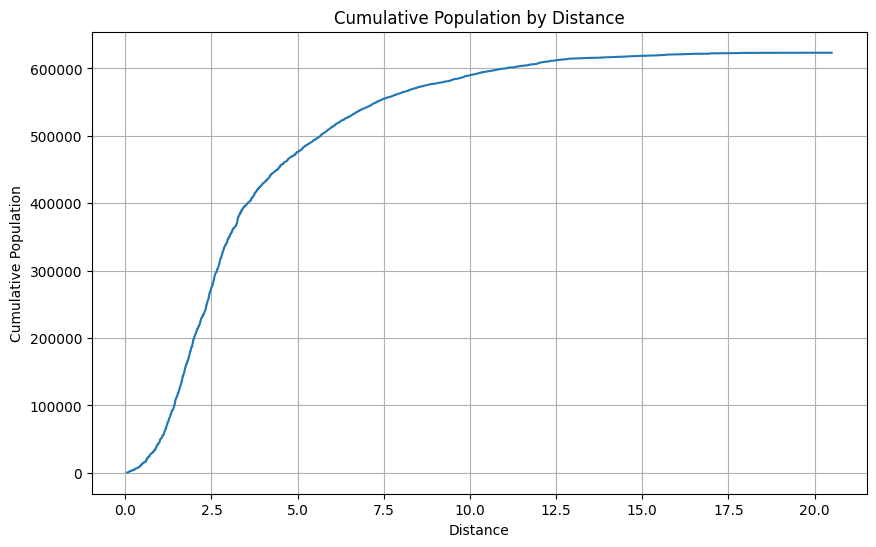

In [41]:
# ----- 여기는 현실판
G = nx.Graph()
for idx,row in nodes.iterrows():
    # add node to Graph G
    G.add_node(row['Id'],Label=row['NODE_NAME'],latitude=row['latitude'], longitude=row['longitude'])
for idx,row in jeju_links.iterrows():
    # Link attribute : 'Source', 'Target' and weight = '시간 between two nodes'
    G.add_edge(row['Source'],row['Target'],weight = row['시간'])
G = connectRes(G, car)
realNodes = [i for i in range(26)]
area = serviceArea(G, realNodes, 40)
print(len(area))
result_df = pd.DataFrame(list(area.items()), columns=['ID', 'Distance'])
merged_df = pd.merge(result_df, nodes[['Id', 'average population']], left_on='ID', right_on='Id')
grouped_data = merged_df.groupby('Distance')['average population'].sum()
cumulative_population = grouped_data.cumsum()

# ------- 여기는 랜덤판
result_x = []
result_y = []
iter = 0
for pointsList in randomPoints:
    iter +=1
    G = nx.Graph()
    for idx,row in nodes.iterrows():
        # add node to Graph G
        G.add_node(row['Id'],Label=row['NODE_NAME'],latitude=row['latitude'], longitude=row['longitude'])
    for idx,row in jeju_links.iterrows():
        # Link attribute : 'Source', 'Target' and weight = '시간 between two nodes'
        G.add_edge(row['Source'],row['Target'],weight = row['시간'])    
    # make a dictionary for node position
    columns = ['longitude','latitude']
    df = pd.DataFrame(pointsList, columns=columns)
    G = connectRes(G, df)
    random_nodes = [i for i in range(26)]
    area = serviceArea(G, random_nodes, 40)
    print(len(area))
    random_df = pd.DataFrame(list(area.items()), columns=['ID', 'Distance'])
    random_counts = [random_df[random_df['Distance'] <= distance].shape[0] for distance in distances]
    mergedRandom = pd.merge(random_df, nodes[['Id', 'average population']], left_on='ID', right_on='Id')
    groupedRandom = mergedRandom.groupby('Distance')['average population'].sum()
    randomPopulation = groupedRandom.cumsum()
    
    x = distances
    if len(x) > len(result_x):
        result_x = x
    if len(result_x) > len(cumulative_population.index):
        result_x = result_x[:len(cumulative_population.index)]
    y = randomPopulation.values.tolist()
    print(len(y), y[-1])
    if len(y) > len(cumulative_population.values):
        y = y[:len(cumulative_population.values)]
    if result_y == []:
        result_y = y
    else:
        for i in range(len(y)):
            result_y[i] = result_y[i] + y[i]
result_y = [y/10 for y in result_y]
print(len(result_x), result_x)
print(len(result_y), result_y)


distances = sorted(result_df['Distance'].unique())
cumulative_counts = [result_df[result_df['Distance'] <= distance].shape[0] for distance in distances]

plt.figure(figsize=(10, 6))
plt.plot(cumulative_population.index, cumulative_population.values, marker='o', markersize = 0)
plt.plot(result_x, result_y, marker='o', markersize = 0)
plt.xlabel('Distance')
plt.ylabel('Cumulative Population')
plt.title('Cumulative Population by Distance')
plt.grid(True)
plt.savefig('result/Population by Distance.png')
plt.show()